In [28]:
import itertools
import json
import tempfile
from os import path

import invest_ucm_calibration as iuc
import pandas as pd
import rasterio as rio
import seaborn as sns
import swiss_uhi_utils as suhi
import xarray as xr
from affine import Affine
from tqdm import tqdm

from lausanne_greening_scenarios.invest import utils as invest_utils

# register tqdm with pandas to be able to use `progress_apply`
tqdm.pandas()

In [2]:
scenario_metrics_filepath = '../data/interim/scenario-metrics.csv'
scenario_lulc_filepath = '../data/interim/scenario-da.nc'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
ref_et_da_filepath = '../data/interim/invest/ref-et.nc'
t_da_filepath = '../data/processed/tair-ucm.nc'
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'

In [4]:
scenario_metrics_df = pd.read_csv(scenario_metrics_filepath)
scenario_metrics_df = scenario_metrics_df.groupby(['interaction', 'change_prop']).mean().drop('scenario_run', axis=1).reset_index()

In [37]:
scenario_lulc_da = xr.open_dataarray(scenario_lulc_filepath)
rio_meta = scenario_lulc_da.attrs.copy()
scenario_lulc_da = scenario_lulc_da.mean('scenario_run').round().astype(rio_meta['dtype'])
scenario_dims = scenario_lulc_da.coords.dims[:-2]
# nodata = scenario_lulc_da.attrs['nodata']
change_props = scenario_lulc_da['change_prop'].values
rio_meta['transform'] = Affine.from_gdal(*rio_meta['transform'])

In [42]:
with open(calibrated_params_filepath) as src:
    model_params = json.load(src)

In [43]:
t_da = xr.open_dataarray(t_da_filepath)
hottest_day = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())['time'].dt.strftime('%Y-%m-%d').item()
# hottest_day = '2019-07-24'
t_ref = t_da.sel(time=hottest_day).min(dim=['x', 'y']).item()
uhi_max = t_da.sel(time=hottest_day).max(dim=['x', 'y']).item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=hottest_day)
ref_et_raster_dir = '../data/interim'
ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
    ref_et_da, hottest_day, ref_et_raster_dir, invest_utils.get_da_rio_meta(ref_et_da))

In [44]:
# define the functions so that the fixed arguments are curried into them,
# except for `metrics`
def compute_t_avg(row):
    # landscape_arr = sg.generate_landscape_arr(shade_threshold,
    #                                           row['change_prop'],
    #                                           interaction=row['interaction'])
    lulc_arr = scenario_lulc_da.sel({
        scenario_dim: row[scenario_dim]
        for scenario_dim in scenario_dims
    }).values

    with tempfile.TemporaryDirectory() as tmp_dir:
        lulc_raster_filepath = path.join(tmp_dir, 'lulc.tif')
        with rio.open(lulc_raster_filepath, 'w', **rio_meta) as dst:
            dst.write(lulc_arr, 1)

        ucm_wrapper = iuc.UCMWrapper(lulc_raster_filepath, biophysical_table_filepath, 'factors', ref_et_raster_filepath, t_ref, uhi_max, extra_ucm_args=model_params)
        return ucm_wrapper.predict_t_da().mean(skipna=True).item()

In [47]:
scenario_metrics_df['T_avg'] = scenario_metrics_df.progress_apply(compute_t_avg, axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

  9%|▉         | 2/22 [00:36<06:05, 18.26s/it]

 14%|█▎        | 3/22 [01:15<07:44, 24.43s/it]

 18%|█▊        | 4/22 [01:53<08:31, 28.43s/it]

 23%|██▎       | 5/22 [02:30<08:50, 31.20s/it]

 27%|██▋       | 6/22 [03:06<08:42, 32.64s/it]

 32%|███▏      | 7/22 [03:45<08:35, 34.37s/it]

 36%|███▋      | 8/22 [04:23<08:18, 35.59s/it]

 41%|████      | 9/22 [04:58<07:40, 35.42s/it]

 45%|████▌     | 10/22 [05:35<07:10, 35.86s/it]

 50%|█████     | 11/22 [06:11<06:33, 35.79s/it]

 55%|█████▍    | 12/22 [06:47<05:58, 35.87s/it]

 59%|█████▉    | 13/22 [07:22<05:22, 35.83s/it]

 64%|██████▎   | 14/22 [07:58<04:45, 35.68s/it]

 68%|██████▊   | 15/22 [08:33<04:08, 35.53s/it]

 73%|███████▎  | 16/22 [09:07<03:30, 35.13s/it]

 77%|███████▋  | 17/22 [09:42<02:54, 34.95s/it]

 82%|████████▏ | 18/22 [10:19<02:22, 35.60s/it]

 86%|████████▋ | 19/22 [10:56<01:48, 36.08s/it]

 91%|█████████ | 20/22 [11:32<01:11, 35.95s/it]

 95%|█████████▌| 21/22 [12:07<00:35, 35.78s/it]

100%|██████████| 22/22 [12:42<00:00, 35.54s/it]

100%|██████████| 22/22 [13:18<00:00, 36.31s/it]

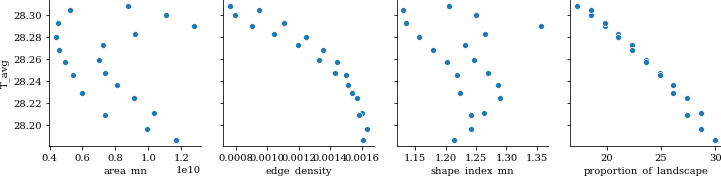

In [ ]:
sns.pairplot(scenario_metrics_df, x_vars=scenario_metrics_df.columns[2:-1], y_vars=['T_avg'])

### Do the spatial regression by zones

In [56]:
from lausanne_greening_scenarios.regression import utils as regr_utils

In [ ]:
metrics = ['proportion_of_landscape', 'area_mn', 'shape_index_mn', 'edge_density']
tree_class = utils.TREE_CLASS

In [ ]:
rw = regr_utils.RegressionWrapper(lulc_raster_filepath, biophysical_table_filepath, metrics, tree_class)